In [ ]:
#now create CNN that can generate new images
#tutorials online (don't use GANs - try with an autoencoder)
#down the line, will make a variational autoencoder (start with autoencoder though)

# part 1 = neural network architecutre (layers, parameters, size)
# part 2 = model class (GAN, variational autoencoder, diffusion model, FLOW model)
# [combination of how think about model & how structure the system to make your model]

In [2]:
import torch
from torchvision import datasets,transforms
import numpy as np
from matplotlib import pyplot as plt
from torchvision.utils import make_grid

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

print(train_dataset)

batchSize=128

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchSize, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batchSize, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 14000686.72it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 468947.46it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4261119.93it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2235977.55it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist_data/
    Split: Train
    StandardTransform
Transform: ToTensor()


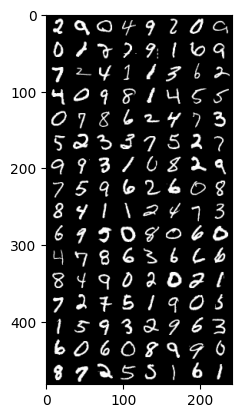

In [6]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

examples, _ = next(iter(train_loader))
examples_show = make_grid(examples)

imshow(examples_show)

In [13]:
#Network building

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

num_hidden_1 = 256
num_hidden_2 = 128
num_input = 784 # (MNIST is 28*28)

#building encoder & decoder
class Autoencoder(nn.Module):
  def __init__(self, x_dim, h_dim1, h_dim2):
    super(Autoencoder, self).__init__()
    #encoder part
    self.fc1 = nn.Linear(x_dim, h_dim1)
    self.fc2 = nn.Linear(h_dim1, h_dim2)
    #decoder part
    self.fc3 = nn.Linear(h_dim2, h_dim1)
    self.fc4 = nn.Linear(h_dim1, x_dim)

  def encoder(self, x):
    x = torch.sigmoid(self.fc1(x))
    x = torch.sigmoid(self.fc2(x))
    return x

  def decoder(self, x):
    x = torch.sigmoid(self.fc3(x))
    x = torch.sigmoid(self.fc4(x))
    return x

  def forward(self, x):
      x = self.encoder(x)
      x = self.decoder(x)
      return x

model = Autoencoder(num_input, num_hidden_1, num_hidden_2)

In [22]:
#Training

optimizer = optim.Adam(model.parameters())
epoch = 10
loss_function = nn.MSELoss()

print('Training...')
for i in range(epoch):
  train_loss = 0
  for batch_idx, (data, _) in enumerate(train_loader):
    #prepare input data
    inputs = torch.reshape(data,(-1, 784))
    #set gradient to zero
    optimizer.zero_grad()
    #feed inputs into model
    recon_x = model(inputs)
    #calculating loss
    loss = loss_function(recon_x, inputs)
    #calculate gradient of each parameter
    loss.backward()
    train_loss += loss.item()
    #update weight based on calculated gradient
    optimizer.step()
  if i % 10 == 0:
    print('Epoch: {} Average loss: {:.9f}'.format(i, train_loss))
print('Training finished.')

Training...
Epoch: 0 Average loss: 30.679630995
Training finished.


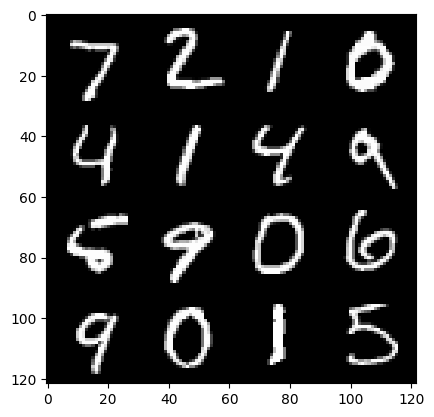

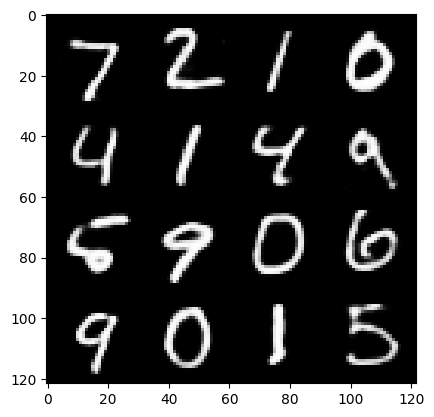

In [ ]:
#load 16 imgs from test set
inputs, _ = next(iter(test_loader))
inputs_example = make_grid(inputs[:16,:,:,:],4)
imshow(inputs_example)

#convert img->tensor
inputs = torch.reshape(inputs,(-1,784))

#get outputs from trained model
outputs = model(inputs)

#convert tensor->img
outputs=torch.reshape(outputs,(-1,1,28,28))
outputs=outputs.detach().cpu()

#show output images
outputs_example = make_grid(outputs[:16,:,:,:],4)
imshow(outputs_example)

#WOW, retains basically all the information (if not making it cleaner!)

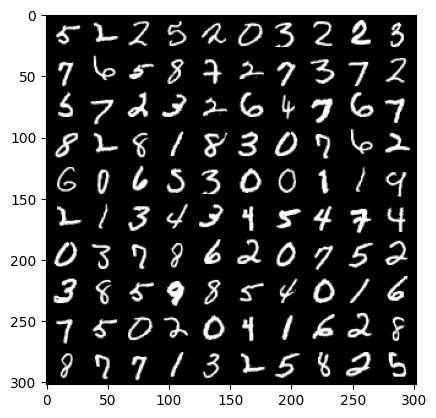

tensor([[5, 2, 2, 5, 2, 0, 3, 2, 2, 3],
        [7, 6, 5, 8, 7, 2, 7, 3, 7, 2],
        [5, 7, 2, 3, 2, 6, 4, 7, 6, 7],
        [8, 2, 8, 1, 8, 3, 0, 7, 6, 2],
        [6, 0, 6, 5, 3, 0, 0, 1, 1, 9],
        [2, 1, 3, 4, 3, 4, 5, 4, 7, 4],
        [0, 3, 7, 8, 6, 2, 0, 7, 5, 2],
        [3, 8, 5, 9, 8, 5, 4, 0, 1, 6],
        [7, 5, 0, 2, 0, 4, 1, 6, 2, 8],
        [8, 7, 7, 1, 3, 2, 5, 8, 2, 5]])


In [ ]:
#Evals

#get 100 image-label pairs from training set
x_train, y_train = next(iter(train_loader))

#10 classes, 10 samples per class, 100 in total
candidates = np.random.choice(batchSize, 10*10)

#randomly select 100 samples
x_train = x_train[candidates]
y_train = y_train[candidates]

#display selected samples and print their labels
imshow(make_grid(x_train[:100,:,:,:],10))
print(y_train.reshape(10, 10))

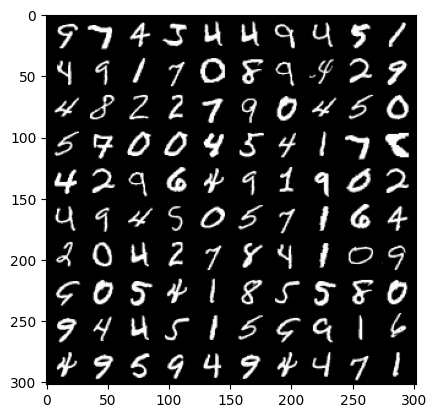

tensor([[9, 7, 4, 3, 4, 4, 9, 4, 5, 1],
        [4, 9, 1, 7, 0, 8, 9, 4, 2, 9],
        [4, 8, 2, 2, 7, 9, 0, 4, 5, 0],
        [5, 7, 0, 0, 4, 5, 4, 1, 7, 8],
        [4, 2, 9, 6, 4, 9, 1, 9, 0, 2],
        [4, 9, 4, 5, 0, 5, 7, 1, 6, 4],
        [2, 0, 4, 2, 7, 8, 4, 1, 0, 9],
        [9, 0, 5, 4, 1, 8, 5, 5, 8, 0],
        [9, 4, 4, 5, 1, 5, 9, 9, 1, 6],
        [4, 9, 5, 9, 4, 9, 4, 4, 7, 1]])


In [ ]:
#get 100 image-label pairs from test set
x_test, y_test = next(iter(train_loader))
candidates_test = np.random.choice(batchSize, 10*10)

x_test = x_test[candidates_test]
y_test = y_test[candidates_test]

#display selected samples and print their labels
imshow(make_grid(x_test[:100,:,:,:],10))

print(y_test.reshape(10, 10))

In [ ]:
#compute the representations of training and test samples
h_train = model.encoder(torch.reshape(x_train,(-1,784)))
h_test = model.encoder(torch.reshape(x_test,(-1,784)))

#find nearest training samples to each test instance, in terms of MSE
MSEs = np.mean(np.power(np.expand_dims(h_test.detach().cpu(), axis=1) - np.expand_dims(h_train.detach().cpu(), axis=0), 2), axis=2)
neighbours = MSEs.argmin(axis=1)
predicts = y_train[neighbours]

# print(np.stack([y_test, predicts], axis=1))
print('Recognition accuracy according to the learned representation is %.1f%%' % (100 * (y_test == predicts).numpy().astype(np.float32).mean()))

Recognition accuracy according to the learned representation is 76.0%


torch.Size([128])


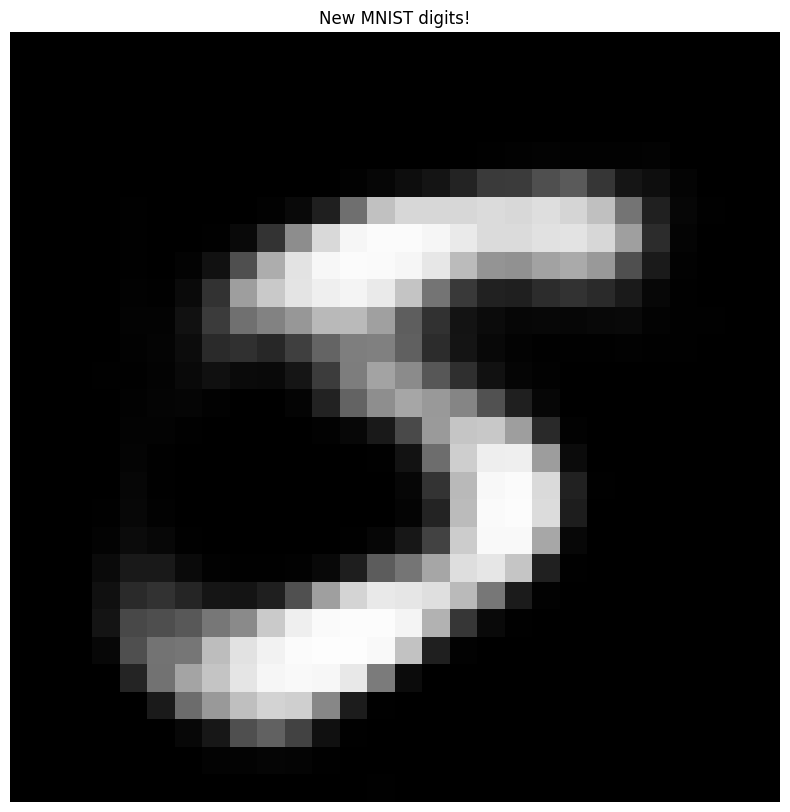

In [74]:
#generate new MNIST-like digits
num_gen = 16

#generate random latent vectors
img, label = train_dataset[0]

#generate images from random latent vectors
with torch.no_grad():
  img = img.view(-1)
  latent_vectors = model.encoder(img)
  latent_vectors = latent_vectors + torch.randn_like(latent_vectors) * 0.3
  print(latent.shape)
  generated_images = model.decoder(latent_vectors)
  generated_images = generated_images.view(-1, 1, 28, 28)
  geneated_images = torch.clamp(generated_images, 0, 1)

#display generated images
generated_grid = make_grid(generated_images, nrow = 4)
plt.figure(figsize=(10, 10))
plt.imshow(generated_grid.permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.title('New MNIST digits!')
plt.show()

When have latent code for a 1, you want model to generate new images!

how do you do this? you give it a completely different latent code the model wasn't trained on

hopefully still producing same approx digit

after this, do a variational encoder

then can do it all with imagenet